In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf  

In [101]:
import os

# Load and preprocess the data
data = []
labels = []

def extract_person_label(file_name):
    return int(file_name.split('.')[0].replace('subject', '')) - 1  # Subtract 1 to make labels start from 0

dataset_dir = 'C:/Users/Owner/Desktop/Assignment1/yale'

for file_name in os.listdir(dataset_dir):
    img = plt.imread(os.path.join(dataset_dir, file_name))
    # print(img.shape)
    data.append(img.flatten())  # Flatten image into a 1D array
    labels.append(extract_person_label(file_name))

data = np.array(data)
labels = np.array(labels)
unique_labels = np.unique(labels)
print(unique_labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42) #stratify=labels
unique_labels_train = np.unique(y_train)
unique_labels_test = np.unique(y_test)
#print("Unique Labels in Training Data:", unique_labels_train)
#print("Unique Labels in Testing Data:", unique_labels_test)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [102]:
len(X_train),len(y_train)

(132, 132)

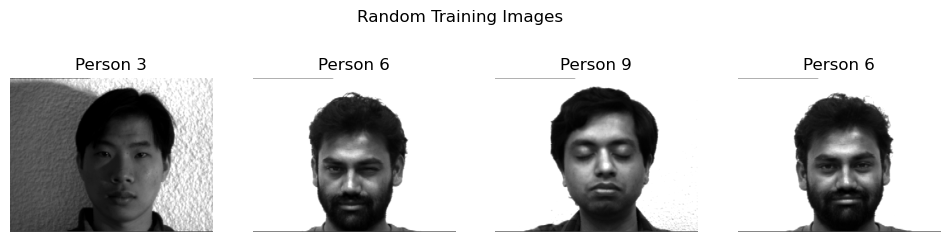

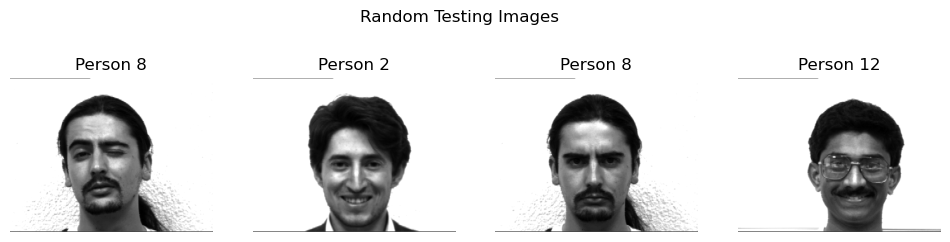

In [103]:
import random

# Randomly select four indices from the training dataset
train_indices = random.sample(range(len(X_train)), 4)

test_indices = random.sample(range(len(X_test)), 4)

def display_images(images, labels, title):
    plt.figure(figsize=(12, 3))
    plt.suptitle(title)
    for i, (image, label) in enumerate(zip(images, labels), 1):
        plt.subplot(1, 4, i)
        plt.imshow(image.reshape((243, 320)), cmap='gray')
        plt.title(f"Person {label}")
        plt.axis('off')
    plt.show()

train_images_to_display = X_train[train_indices]
train_labels_to_display = y_train[train_indices]
display_images(train_images_to_display, train_labels_to_display, "Random Training Images")

test_images_to_display = X_test[test_indices]
test_labels_to_display = y_test[test_indices]
display_images(test_images_to_display, test_labels_to_display, "Random Testing Images")

In [115]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

#The MLPClassifier class encapsulates an easy-to-use Multi-Layer Perceptron (MLP) neural network for classification tasks. 
#It offers methods for building, training, tuning, and evaluating the model, streamlining the process of working with MLPs.

class MLPClassifier:
   
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.model = None

    def build_model(self, hidden_layers, activation='relu'):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=(self.input_size,)))
        for units in hidden_layers:
            model.add(tf.keras.layers.Dense(units, activation=activation))
        model.add(tf.keras.layers.Dense(self.output_size, activation='softmax'))
        return model

    def fit(self, X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2):
        self.model = self.build_model(hidden_layers=[128, 64])
        custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Set your desired learning rate
        self.model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        #self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=2)
        return history

    def test(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        return accuracy, precision, recall, f1

    def tune(self, param_grid, X_train, y_train, cv=3):
        custom_scorer = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
            'f1': make_scorer(f1_score, average='macro')
        }
        grid_search = GridSearchCV(self.build_model([]), param_grid, cv=cv, n_jobs=-1, verbose=2, scoring=custom_scorer, refit='accuracy')
        grid_search.fit(X_train, y_train)
        return grid_search.best_params_
    

    def evaluate(self, X_test, y_test):
        accuracy, precision, recall, f1 = self.test(X_test, y_test)
        return accuracy, precision, recall, f1

unique_labels_train = np.unique(y_train)
unique_labels_test = np.unique(y_test)
#print("Unique Labels in Training Data:", unique_labels_train)
#print("Unique Labels in Testing Data:", unique_labels_test)
    


In [116]:
# Instantiate the MLPClassifier, fit and evaluate Model
input_size = X_train.shape[1]
output_size = 15  # Adjust based on the number of output classes
mlp = MLPClassifier(input_size, output_size)

history = mlp.fit(X_train, y_train, 
        epochs=70, 
        batch_size=64, 
        validation_split=0.1, 
        verbose=1)

accuracy, precision, recall, f1 = mlp.evaluate(X_test, y_test)
    
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/70
2/2 - 2s - loss: 8779.8076 - accuracy: 0.0857 - val_loss: 15899.8369 - val_accuracy: 0.0000e+00 - 2s/epoch - 909ms/step
Epoch 2/70
2/2 - 0s - loss: 13830.8838 - accuracy: 0.0857 - val_loss: 12962.5566 - val_accuracy: 0.0741 - 257ms/epoch - 128ms/step
Epoch 3/70
2/2 - 0s - loss: 10605.4121 - accuracy: 0.0571 - val_loss: 8503.2070 - val_accuracy: 0.0370 - 262ms/epoch - 131ms/step
Epoch 4/70
2/2 - 0s - loss: 6645.8594 - accuracy: 0.1619 - val_loss: 8590.1787 - val_accuracy: 0.1111 - 259ms/epoch - 130ms/step
Epoch 5/70
2/2 - 0s - loss: 6215.0605 - accuracy: 0.1714 - val_loss: 4178.1909 - val_accuracy: 0.0370 - 262ms/epoch - 131ms/step
Epoch 6/70
2/2 - 0s - loss: 3473.6057 - accuracy: 0.1429 - val_loss: 3268.9048 - val_accuracy: 0.2963 - 261ms/epoch - 130ms/step
Epoch 7/70
2/2 - 0s - loss: 3502.2068 - accuracy: 0.2095 - val_loss: 2491.5217 - val_accuracy: 0.1852 - 271ms/epoch - 135ms/step
Epoch 8/70
2/2 - 0s - loss: 2719.5393 - accuracy: 0.2095 - val_loss: 2297.4861 - val_accurac

Epoch 65/70
2/2 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 110.2735 - val_accuracy: 0.7407 - 264ms/epoch - 132ms/step
Epoch 66/70
2/2 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 111.3549 - val_accuracy: 0.7407 - 264ms/epoch - 132ms/step
Epoch 67/70
2/2 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 112.2377 - val_accuracy: 0.7407 - 259ms/epoch - 130ms/step
Epoch 68/70
2/2 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 112.9622 - val_accuracy: 0.7407 - 254ms/epoch - 127ms/step
Epoch 69/70
2/2 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 113.5843 - val_accuracy: 0.7037 - 244ms/epoch - 122ms/step
Epoch 70/70
2/2 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 114.1346 - val_accuracy: 0.7037 - 264ms/epoch - 132ms/step
2/2 [==============================] - 0s 24ms/step
Accuracy: 0.8181818181818182
Precision: 0.8928571428571429
Recall: 0.8666666666666668
F1 Score: 0.8441043083900227


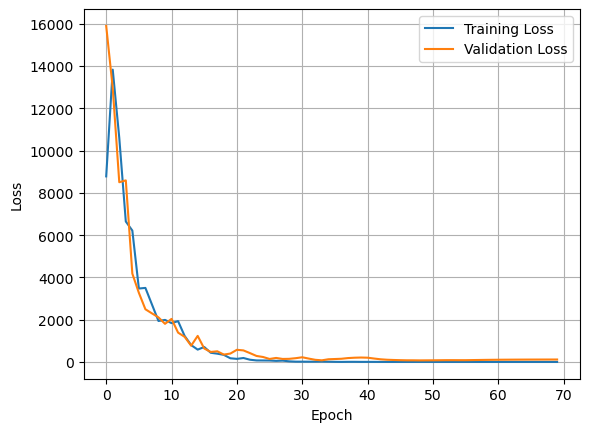

In [117]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

2/2 [==============================] - 0s 11ms/step


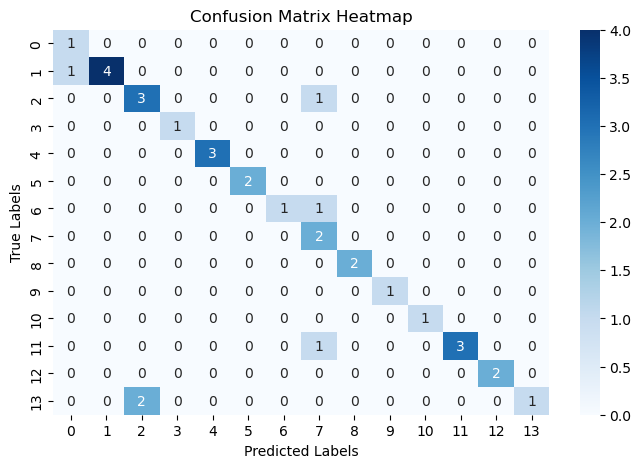

In [118]:
# Calculate the confusion matrix

import seaborn as sns

y_pred = mlp.model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:

# import numpy as np
# import tensorflow as tf
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.metrics import make_scorer
# from sklearn.utils import class_weight
# import warnings

# warnings.filterwarnings("ignore")

# # Define a custom scorer for GridSearchCV
# custom_scorer = {
#     'accuracy': make_scorer(accuracy_score),
#     'precision': make_scorer(precision_score, average='macro'),
#     'recall': make_scorer(recall_score, average='macro'),
#     'f1': make_scorer(f1_score, average='macro')
# }

# # Define your MLP model as a function
# def create_model(input_size, output_size, hidden_layers=[128, 64], activation='relu', optimizer='adam'):
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Input(shape=(input_size,)))
#     for units in hidden_layers:
#         model.add(tf.keras.layers.Dense(units, activation=activation))
#     model.add(tf.keras.layers.Dense(output_size, activation='softmax'))
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Wrap your Keras model in a scikit-learn estimator
# mlp = KerasClassifier(build_fn=create_model, input_size=X_train.shape[1], output_size=15, verbose=2)

# # Define hyperparameters for tuning
# param_grid = {
#     'hidden_layers': [[128, 64]],
#     'activation': ['relu', 'sigmoid'],
#     'epochs': [30],
#     'batch_size': [64],
#     'optimizer': ['adam', 'sgd']
# }

# grid_search = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1, verbose=2, scoring=custom_scorer, refit='accuracy')

# # Perform grid search
# grid_search.fit(X_train, y_train)

# # Get the best parameters and estimator from the grid search
# best_params = grid_search.best_params_
# best_estimator = grid_search.best_estimator_

# # Evaluate the best estimator
# y_pred = best_estimator.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='macro')
# recall = recall_score(y_test, y_pred, average='macro')
# f1 = f1_score(y_test, y_pred, average='macro')

# print(f"Best Parameters: {best_params}")
# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")

